In [1]:
#set adequate environment
import os
import sys
import theano
import keras
theano.config.gcc.cxxflags = '-march=corei7'

#load needed things
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.layers import Input, Activation, Dense
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
#import itertools
import math
import ROOT

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


In [2]:
#here just a quadratic function (parabolic: f(x) = a.x**2 + b)
w = 0.6
b = 1
def func(x, w, b):
    fx = w/x + b
    return fx

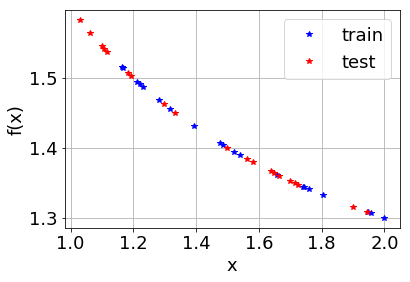

In [3]:
#prepare train and test set
X = {'train':[],'test':[]}
Y = {'train':[],'test':[]}

#produces the distribution to fit
npoints = 20
xmin = 1
xmax = 2
rd = ROOT.TRandom3()
for iset in ['train','test']:
    for j in range(npoints):
        x = rd.Uniform(xmin,xmax)
        if(x != 0):
            fx = func(x, w, b)
            X[iset].append( x )
            Y[iset].append( fx )
    
#plot distribution
pyp.rc("font", size=18)
pyp.plot(X['train'], Y['train'], '*', color='blue', label='train')
pyp.plot(X['test'], Y['test'], '*', color='red', label='test')
pyp.xlabel('x')
pyp.ylabel('f(x)')
pyp.grid(True)
pyp.legend()
pyp.show()


In [4]:
#plot Loss space
loss_name = 'mine'
lw = []
lb = []
lL = []

resolution = 60
lmin = 100000
wmin = 0
bmin = 0
sw = 3
sb = 3
for iw in range(int(w-sw),int(w+sw)):
    for r1 in range(resolution):
        iiw = iw + r1/float(resolution)
        for ib in range(int(b-sb),int(b+sb)):
            for r2 in range(resolution):
                iib = ib + r2/float(resolution)
                #print iiw,iib
                for ix in range(len(X['train'])):
                    y = Y['train'][ix]
                    yl = func(X['train'][ix], iiw, iib)
                    if(loss_name == "mae"):
                        il = math.fabs(y-yl)
                    if(loss_name == "mse"):
                        il = 0.5*pow(y-yl,2)
                    if(loss_name == "mine"):
                        il = math.sqrt(math.fabs((y-yl)/float(y+yl+0.00001)))
                    
                    lw.append( iiw )
                    lb.append( iib )
                    lL.append( il )
                    if(il < lmin):
                        lmin = il
                        wmin = iiw
                        bmin = iib
                    #print "p1: %.3f, p2: %.3f, L: %.3f" % (wmin,bmin,lmin)
print "wmin: %.2f, bmin: %.2f, Lmin: %.2f" % (wmin, bmin, lmin)

wmin: 0.60, bmin: 1.00, Lmin: 0.00


In [5]:
# updatable plot
from IPython.display import clear_output
from keras import backend as K
from matplotlib.colors import LogNorm

class Tscheduler(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accs = []
        #self.val_accs = []
        self.logs = []
        self.ws = []
        self.bs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        #self.val_accs.append(logs.get('val_acc'))
        #getting the updated parameters
        for layer in model.layers:
            weights = layer.get_weights() # list of numpy arrays
            
        nw = weights[0][0]
        nb = weights[1][0]
        self.ws.append(nw)
        self.bs.append(nb)
        self.i += 1
        
        clear_output(wait=True)
        fig = pyp.figure()
        fig.set_figheight(6)
        fig.set_figwidth(17)
        pyp.rc("font", size=18)

        fig1 = fig.add_subplot(131)
        pyp.plot(self.x, self.losses, label="tloss: %f" % self.losses[len(self.losses)-1]) 
        pyp.plot(self.x, self.val_losses, label="vloss: %f" % self.val_losses[len(self.val_losses)-1])
        pyp.xlabel('epochs')
        pyp.ylabel('Loss')
        pyp.title('Training evolution')
        pyp.legend()
        pyp.grid(True)
        
        fig2 = fig.add_subplot(132)
        pyp.plot(self.ws, self.bs, color='blue', label="w: %.2f, b: %.2f" % (self.ws[len(self.ws)-1],self.bs[len(self.bs)-1]))
        pyp.hist2d(lw, lb, bins=resolution, weights=lL, norm=LogNorm())
        pyp.xlabel("weight (exp= %.1f)" % w)
        pyp.ylabel("bias (exp= %.1f)" % b)
        p1 = [w]
        p2 = [b]
        e = [0]
        pyp.errorbar(p1, p2, e, fmt='o', color='red', label='Minimum')
        pyp.colorbar()
        pyp.title('Parameters finding evolution')
        pyp.legend()
        pyp.grid(True)

        fig3 = fig.add_subplot(133)
        pyp.plot(X['train'], Y['train'], '*', color='blue', label='train')
        pyp.plot(X['test'], Y['test'], '*', color='red', label='test')
        pyp.xlabel('x')
        pyp.ylabel('y')
        p1 = self.ws[len(self.ws)-1]
        p2 = self.bs[len(self.bs)-1]
        pyp.plot([i for i in X['train']], [func(i, p1, p2) for i in X['train']], color='darkgreen', label="Model")
        pyp.xlabel('x')
        pyp.ylabel('f(x)')
        pyp.title('Model finding evolution')
        pyp.legend()
        pyp.grid(True)
        
        pyp.tight_layout()
        fig = pyp.show()

                
            
Tschedule = Tscheduler()

In [6]:
def mine(y_true, y_pred):
    return K.sqrt(K.abs((y_true-y_pred)/(y_true+y_pred+0.00001)))

loss_name = mine

In [7]:
#A NN of just one neuron
model = Sequential()
model.add(Dense(1, input_dim=1, kernel_initializer='uniform', activation='linear'))
model.compile(loss=loss_name, optimizer=SGD(lr=0.1))
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
history1 = model.fit(X['train'], Y['train'], validation_data=(X['test'],Y['test']), epochs=100, batch_size=10, verbose=0, callbacks=[Tschedule])

KeyboardInterrupt: 